In [1]:
%load_ext autoreload
%autoreload 2

# Spillover Figure replication

This is the replication code for the Fig 3 exploring the changes in future severity conditional on proximity exposure to wildfires. In this notebook we replicate:
 - Fig 3: Spillover protection
 - Supplementary Plot 6: Population filtering to calculate effect in just remote fires and Standararized Differences from weighting in SC.
 - Supplementary Plot 7: Additional results per severity class and distance

In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from matplotlib.colors import (
    BoundaryNorm,
    LinearSegmentedColormap,
    ListedColormap,
    to_rgba,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.calculate_estimator import (
    calculate_spillover_estimator,
)
from prescribed.plot import plot_std_diffs, template_plots
from prescribed.utils import calculate_fire_pop_dens

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

### Load necessary data to define treatments and exposure

In [3]:
pop_zip = list(
    Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
)
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob(
        "*.tif"
    )
}

In [4]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

In [5]:
df_test = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
)

In [8]:
df_test

,grid_id,lat,lon,year,donut,wildfire,distance
0,941,449152.596997,-348913.82085,1984,nodata,nodata,NaN
1,942,449152.596997,-347913.82085,1984,nodata,nodata,NaN
2,943,449152.596997,-346913.82085,1984,nodata,nodata,NaN
3,944,449152.596997,-345913.82085,1984,nodata,nodata,NaN
4,945,449152.596997,-344913.82085,1984,nodata,nodata,NaN
...,...,...,...,...,...,...,...
409617,966112,-603847.403003,274086.17915,2021,nodata,nodata,NaN
409618,966113,-603847.403003,275086.17915,2021,nodata,nodata,NaN
409619,966114,-603847.403003,276086.17915,2021,nodata,nodata,NaN
409620,966115,-603847.403003,277086.17915,2021,nodata,nodata,NaN


In [12]:
mtbs_ca

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry,year
23,CA3607412018819840329,None,FK 1817,Wildfire,4557,MTBS,Initial (SS),1462,36.074,-120.188,...,-9999,-9999,9999,9999,-65,-280,-9999,Single scene assessment,"POLYGON ((-16343.833 -218108.534, -16386.414 -...",1984
24,CA3561111844619840526,None,WOODROW,Wildfire,4558,MTBS,Initial (SS),1118,35.611,-118.446,...,-9999,-9999,9999,9999,-25,-145,-225,None,"POLYGON ((141373.003 -266537.799, 141333.625 -...",1984
25,CA3800412064719840624,None,SALT SPRING,Wildfire,4560,MTBS,Initial (SS),4837,38.004,-120.647,...,-9999,-9999,9999,9999,50,-250,-9999,None,"POLYGON ((-58252.099 -1193.286, -58680.012 -68...",1984
26,CA3688312115819840705,None,PACHECO 2,Wildfire,4561,MTBS,Initial (SS),1231,36.883,-121.158,...,-9999,-9999,9999,9999,60,-250,-9999,None,"POLYGON ((-104651.975 -125316.575, -104583.253...",1984
27,CA3557911838819840707,None,BODFISH,Wildfire,4562,MTBS,Extended,23189,35.579,-118.388,...,-25,-9999,-970,-150,50,151,300,Hard to tell burned area on NE corner.,"POLYGON ((146993.221 -265129.284, 147352.865 -...",1984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30315,CA3734911987120210711,D3A00541-DBCB-4519-8B77-B9B4DFEDDD0B,RIVER,Wildfire,10024050,MTBS,Initial,10183,37.332,-119.823,...,-4,23,-970,-150,67,400,690,High and moderate severities are adjusted to b...,"POLYGON ((16228.518 -73698.857, 16237.225 -736...",2021
30320,CA4073512229220210922,0EC52428-9E20-46D4-B4C8-AFCD50F9DDA2,FAWN,Wildfire,10024056,MTBS,Extended,9087,40.718,-122.283,...,24,43,-970,-150,120,296,520,"Based on B10TEL20210924_REFL_30.tif image, mid...","POLYGON ((-192564.061 300463.873, -192566.799 ...",2021
30322,CA4075212333720210731,9CF3A69A-A888-4BCD-AA7A-703D75D47E78,MONUMENT,Wildfire,10024059,MTBS,Extended,226125,40.72,-123.261,...,20,31,-970,-150,115,302,534,22 images were applied for perimeter delineati...,"POLYGON ((-287646.564 323409.688, -287607.291 ...",2021
30329,CA4035012303620210730,938686BB-0F52-47B2-B077-EB307941D939,MCFARLAND,Wildfire,10024077,MTBS,Extended,121554,40.278,-122.919,...,18,32,-970,-150,89,297,543,None,"POLYGON ((-242186.304 261917.433, -242184.53 2...",2021


In [11]:
subset_events

,Event_ID,Ig_Date,Incid_Name,Incid_Type,buffer,total_pop,mean_pop,donut,geometry
0,CA3607412018819840329,1984-03-29,FK 1817,Wildfire,10000,16064.701172,38.068012,POLYGON ((-27996.23001383924 -213657.207147192...,"POLYGON ((-16343.833 -218108.534, -16386.414 -..."
0,CA3561111844619840526,1984-05-26,WOODROW,Wildfire,10000,8442.773438,20.642477,"POLYGON ((145225.22810034823 -276041.36146814,...","POLYGON ((141373.003 -266537.799, 141333.625 -..."
0,CA3800412064719840624,1984-06-24,SALT SPRING,Wildfire,10000,6771.258301,12.200465,POLYGON ((-63666.22634607831 -10238.2714922651...,"POLYGON ((-58252.099 -1193.286, -58680.012 -68..."
0,CA3688312115819840705,1984-07-05,PACHECO 2,Wildfire,10000,45.319866,0.112736,POLYGON ((-114651.83891438913 -125368.77041719...,"POLYGON ((-104651.975 -125316.575, -104583.253..."
0,CA3557911838819840707,1984-07-07,BODFISH,Wildfire,10000,8961.168945,11.547898,POLYGON ((141087.98770318396 -286011.608769358...,"POLYGON ((146993.221 -265129.284, 147352.865 -..."
...,...,...,...,...,...,...,...,...,...
0,CA3797811972120210731,2021-07-31,TILTILL,Wildfire,10000,1.939287,0.004023,POLYGON ((14375.235402214186 -4971.69756398618...,"POLYGON ((27259.529 -2690.986, 27250.849 -2697..."
0,CA3734911987120210711,2021-07-11,RIVER,Wildfire,10000,9177.973633,15.296622,POLYGON ((782.4863761482193 -75507.26908789857...,"POLYGON ((16228.518 -73698.857, 16237.225 -736..."
0,CA4075212333720210731,2021-07-31,MONUMENT,Wildfire,10000,7995.977539,4.319815,POLYGON ((-247495.89710014092 305507.904668873...,"POLYGON ((-287646.564 323409.688, -287607.291 ..."
0,CA4035012303620210730,2021-07-30,MCFARLAND,Wildfire,10000,484.464478,0.325800,POLYGON ((-278627.20411748905 264394.481760099...,"POLYGON ((-242186.304 261917.433, -242184.53 2..."


In [10]:
subset_events[subset_events.Event_ID.isin(df_test.wildfire.tolist())]

,Event_ID,Ig_Date,Incid_Name,Incid_Type,buffer,total_pop,mean_pop,donut,geometry
0,CA3561111844619840526,1984-05-26,WOODROW,Wildfire,10000,8442.773438,20.642477,"POLYGON ((145225.22810034823 -276041.36146814,...","POLYGON ((141373.003 -266537.799, 141333.625 -..."
0,CA3557911838819840707,1984-07-07,BODFISH,Wildfire,10000,8961.168945,11.547898,POLYGON ((141087.98770318396 -286011.608769358...,"POLYGON ((146993.221 -265129.284, 147352.865 -..."
0,CA3640611884819840829,1984-08-29,BAR-O,Wildfire,10000,1818.814697,3.789197,POLYGON ((92074.65493768522 -173435.1286469219...,"POLYGON ((104658.8 -178188.322, 104824.796 -17..."
0,CA4007812006619840705,1984-07-05,TURTLE,Wildfire,10000,3322.746582,9.178858,POLYGON ((-16230.182726707211 234779.126281887...,"POLYGON ((-6040.476 231821.106, -5910.238 2318..."
0,CA4068311999419840706,1984-07-06,TWIN,Wildfire,10000,28.720474,0.056315,POLYGON ((-20445.630552055976 303584.406739581...,"MULTIPOLYGON (((2879.358 295092.507, 2895.361 ..."
...,...,...,...,...,...,...,...,...,...
0,CA3876011973020210701,2021-07-01,EAST FORK,Wildfire,10000,518.959229,1.759184,POLYGON ((12172.370032532572 85740.90181846012...,"POLYGON ((22111.682 82384.359, 22109.256 82389..."
0,CA3797811972120210731,2021-07-31,TILTILL,Wildfire,10000,1.939287,0.004023,POLYGON ((14375.235402214186 -4971.69756398618...,"POLYGON ((27259.529 -2690.986, 27250.849 -2697..."
0,CA4075212333720210731,2021-07-31,MONUMENT,Wildfire,10000,7995.977539,4.319815,POLYGON ((-247495.89710014092 305507.904668873...,"POLYGON ((-287646.564 323409.688, -287607.291 ..."
0,CA4035012303620210730,2021-07-30,MCFARLAND,Wildfire,10000,484.464478,0.325800,POLYGON ((-278627.20411748905 264394.481760099...,"POLYGON ((-242186.304 261917.433, -242184.53 2..."


## Sup Fig 6: Remote Fires using population filter

In [6]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:41<00:00, 45.04it/s]


Fires above 75.0th-percentile: 472
Fires below 75.0th-percentile: 1414


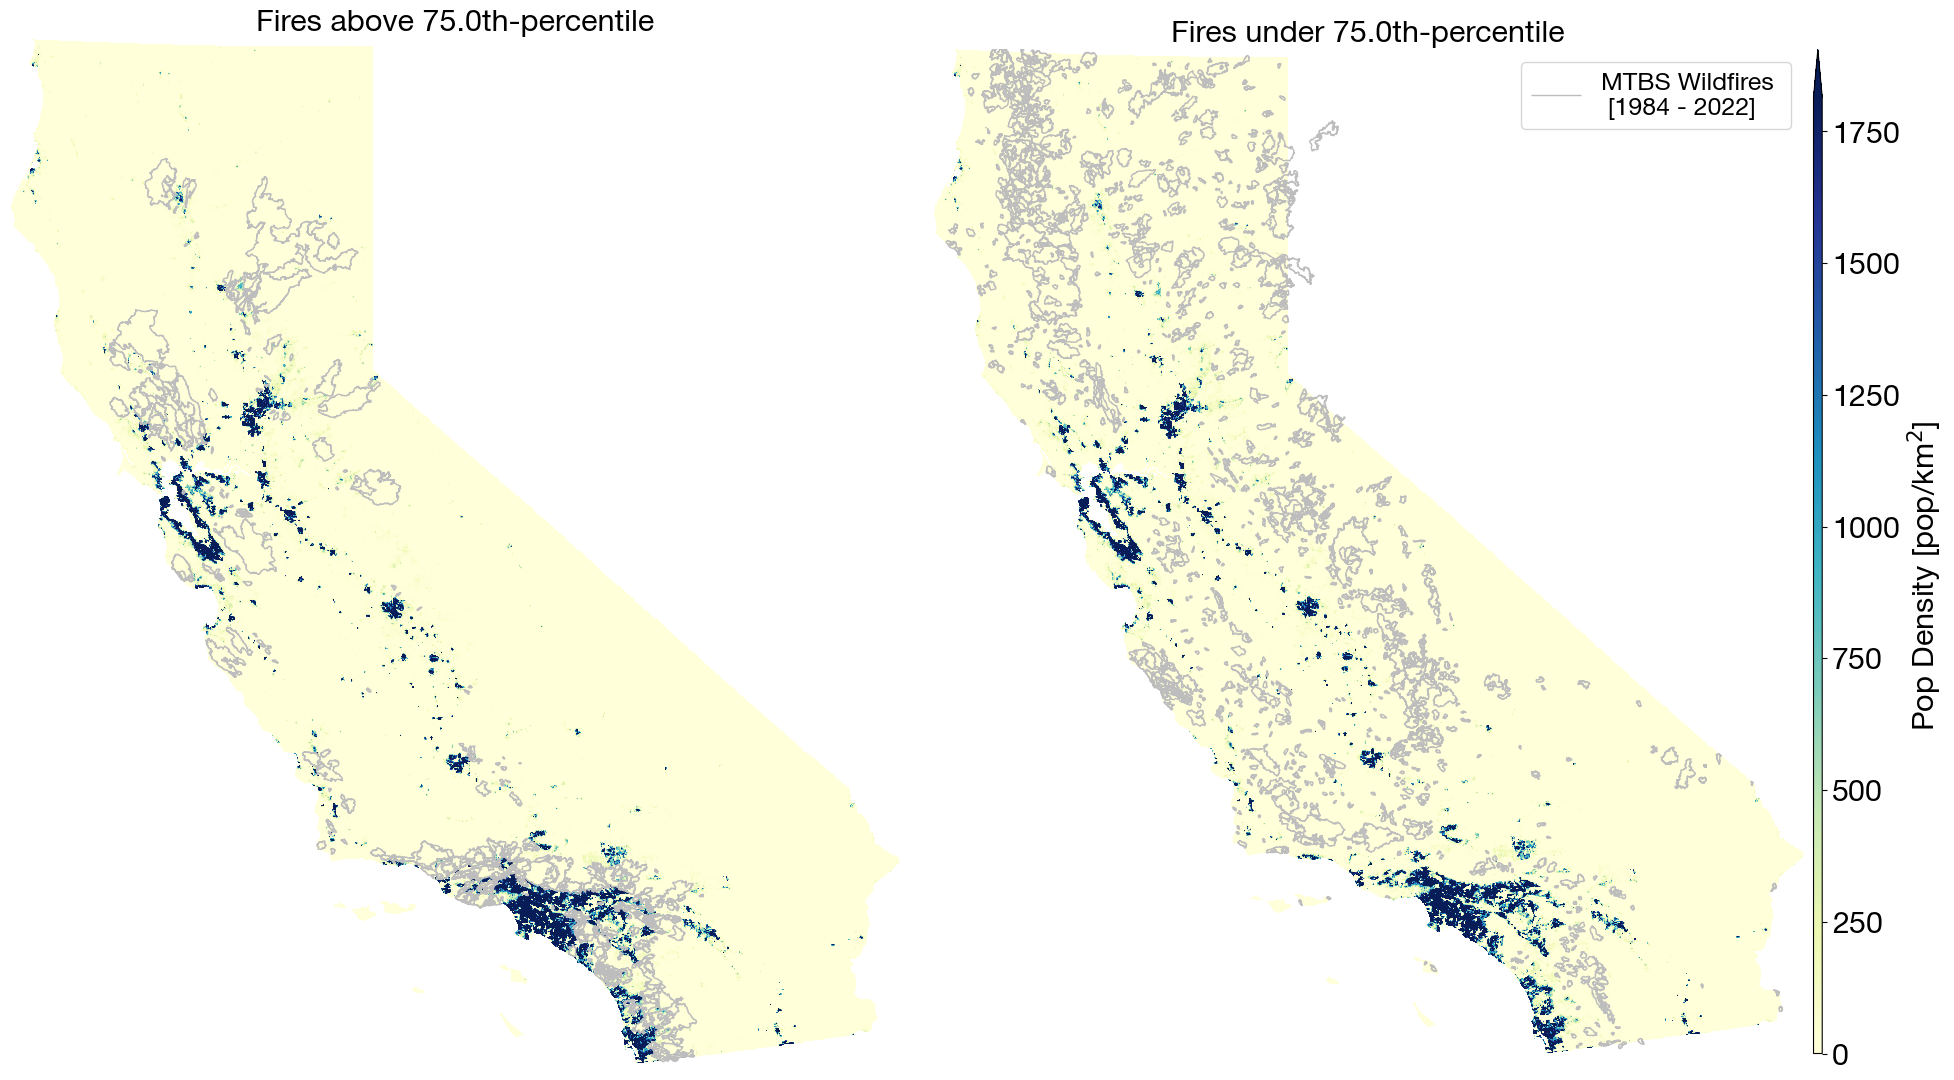

In [7]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22

############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(20, 20))

thresh_def = 0.75

cal_pop.plot(robust=True, ax=ax[0], cmap="YlGnBu", add_colorbar=False)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]
print(f"Fires above {thresh_def * 100}th-percentile: {subset_events.shape[0]}")
subset_events.geometry.boundary.plot(
    ax=ax[0],
    color="#bdbdbd",
    linewidth=1,
    alpha=1,
)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=22)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    rasterized=True,
    cmap="YlGnBu",
    cbar_kwargs={
        "label": r"Pop Density [pop/km$^2$]",
        "shrink": 0.5,
        "aspect": 10,
    },
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

print(f"Fires below {thresh_def * 100}th-percentile: {subset_events.shape[0]}")

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=1,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=18)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=22)

# Save plot
plt.tight_layout()
plt.savefig("../figs/pop_density_fires.pdf", dpi=400, transparent=True)

/tmp/ipykernel_3120549/4193006341.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


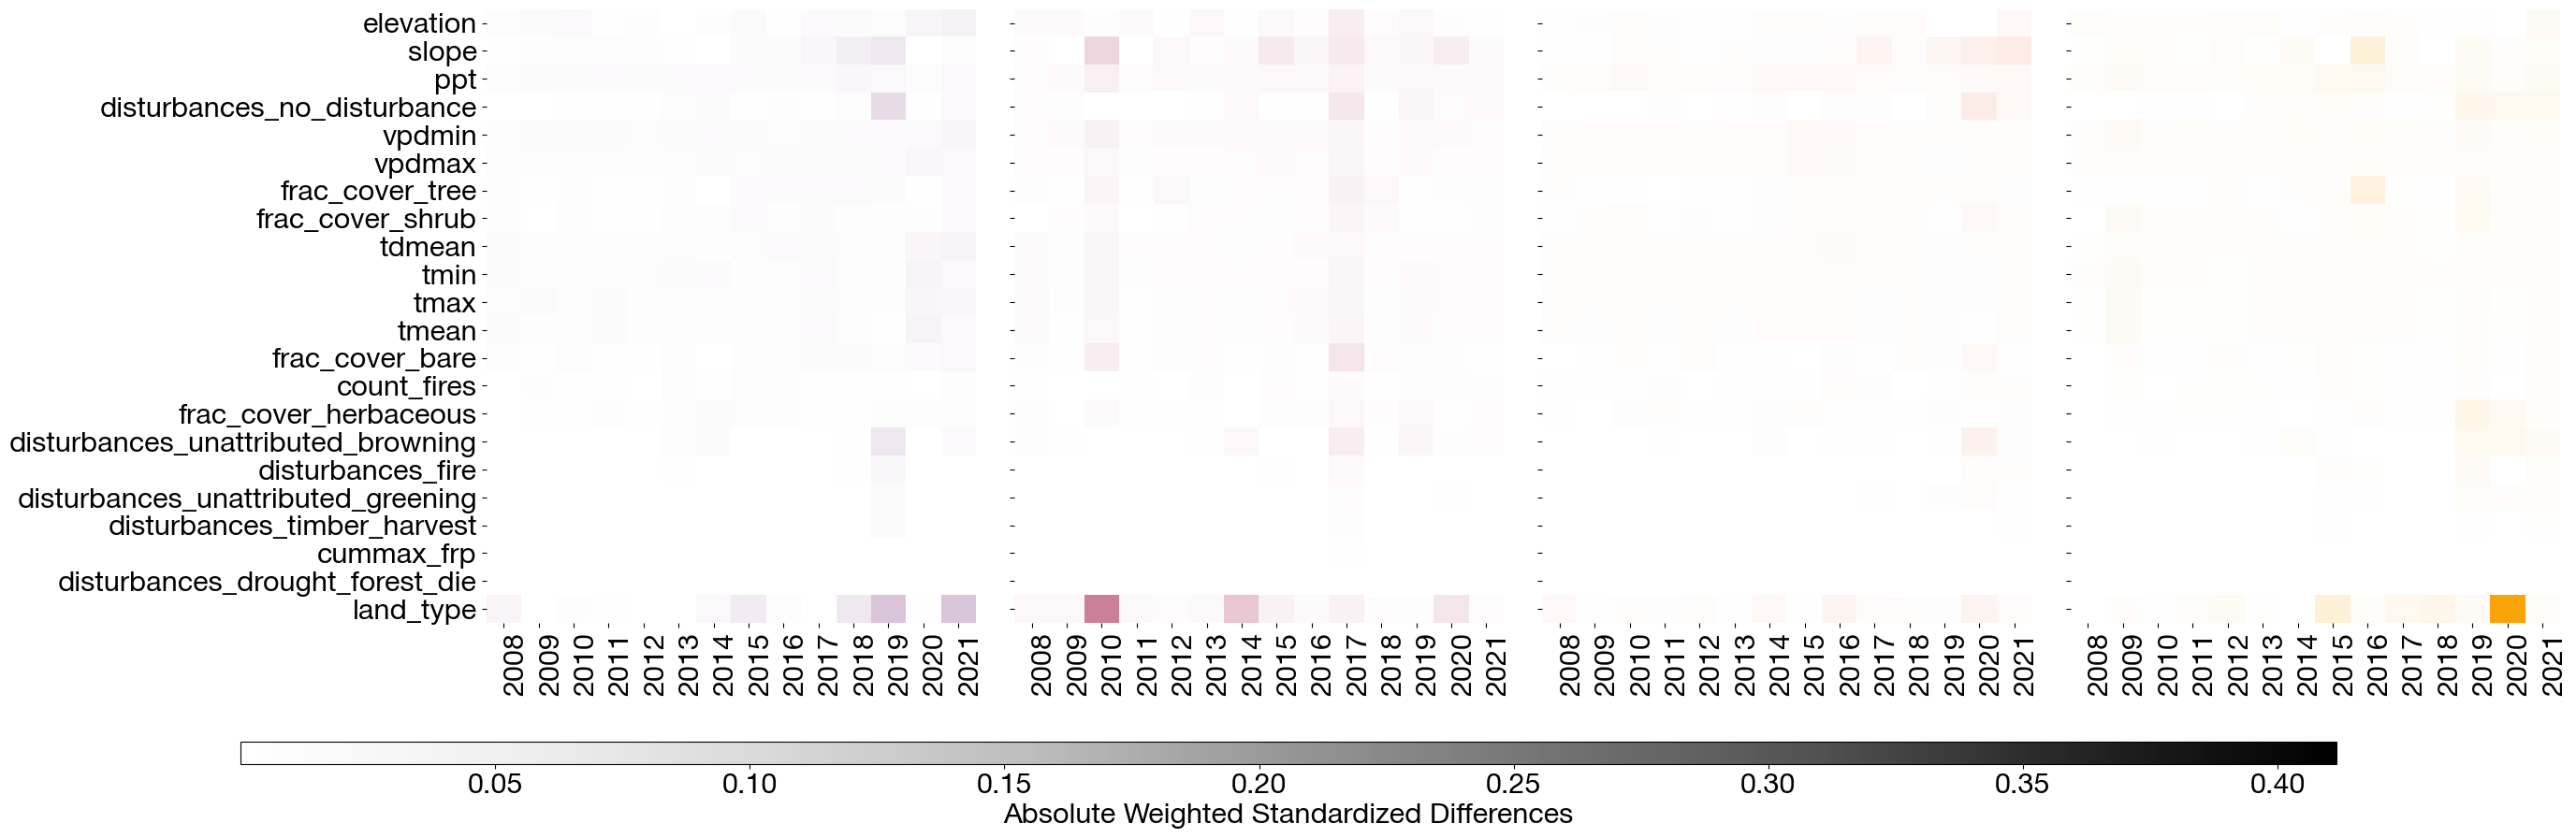

In [10]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22


dists = [2_000, 5_000, 10_000, 15_000]

fig, ax = plt.subplots(
    1, len(dists), figsize=(28, 8), sharey=True, layout="tight"
)
colors = cm.inferno(np.linspace(0.3, 0.8, len(dists)))


min_list = []
max_list = []
for dist, color, ax in zip(dists, colors, ax.flatten()):
    cmap = LinearSegmentedColormap.from_list(
        "", [to_rgba(color, 0), to_rgba(color, 1)]
    )

    _, std_min, std_max = plot_std_diffs(
        std_diffs_df=f"../tyra/treatment_spillovers_{dist}/best_model_asmd_std_diffs.csv",
        palette=cmap,
        ax=ax,
        draw_cbar=False,
        sorted=False,
        labels_y=True,
        rotation_x=90,
        drop_vars=["Intercept", "aspect", "curvature"],
        vmax=0.41154936,
        vmin=8.9584755e-07,
    )
    min_list.append(std_min)
    max_list.append(std_max)

# Add a colorbar at the bottom outside the plot using the max and min of all the data
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=min(min_list), vmax=max(max_list))
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Absolute Weighted Standardized Differences", fontsize=22)

# Save as PDF
plt.savefig(
    "../figs/spillover_std_diffs.pdf",
    dpi=400,
    transparent=False,
    bbox_inches="tight",
    pad_inches=0.1,
)

## Fig 3. Spillover effects of wildfire exposure

In [6]:
test_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
)

dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
# Add years using mtbs data
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID"
)
dnbr["fire"] = 1

# Load FRP data with nominal confidence and fire with everything where FRP > 0
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
).drop(columns=["lat", "lon"])

# Load treat defniitions
treats_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
).drop(columns=["lat", "lon", "donut", "wildfire"])


def classify_dnbr(data):
    # Find the DNBR class from the earliest fire per each grid using the
    # DNBR threshold values from Key & Benson (2006):
    conditions = [
        (data.dnbr < 100),
        (data.dnbr >= 100) & (data.dnbr < 270),
        (data.dnbr >= 270) & (data.dnbr < 440),
        (data.dnbr >= 440) & (data.dnbr < 660),
        data.dnbr >= 660,
    ]
    # zero-index to match the low-intensity level to be 1.
    choices = [0, 1, 2, 3, 4]

    # Asigning FRP class to each fire
    data.loc[:, "class_dnbr"] = np.select(conditions, choices, default=np.nan)
    return data


def classify_frp(df):
    conditions = [
        (df.frp > 0) & (df.frp < 100),
        (df.frp >= 100) & (df.frp < 500),
        (df.frp >= 500) & (df.frp < 1000),
        (df.frp >= 1000) & (df.frp < 1500),
        df.frp >= 1500,
    ]
    choices = [1, 2, 3, 4, 5]

    # Asigning FRP class to each fire
    df["class_frp"] = np.select(conditions, choices, default=np.nan)

    return df


raw_dnbr = classify_dnbr(dnbr)
raw_frp = classify_frp(frp)

In [7]:
hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "High-severity wildfires": [2, 3, 4],
    "Very High-severity wildfires": [3, 4],
}

list_df = []

for key, high_class in hc_lists.items():
    if key == "All wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"
    elif key == "High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"
    elif key == "Very High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "Very High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"

    est_dfs_list = []
    for distance in [2_000, 5_000, 10_000, 15_000]:
        weights = pd.read_csv(
            f"../tyra/treatment_spillovers_{distance}/best_model_asmd_weights.csv"
        )

        past_dist = 0
        df = calculate_spillover_estimator(
            treatments=treats_dist,
            weights=weights,
            fire_data=out_df,
            focal_years=np.arange(2008, 2023),
            max_distance=distance,
            min_distance=past_dist,
            estimator="rr",
            dep_var="fire",
            pooling=True,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_mean",
            max_lags=14,
            rr=True,
        )
        past_dist = distance

        est_dfs_list.append(df)

    df = pd.concat(est_dfs_list)
    df["control_group"] = key
    list_df.append(df)

final_df = pd.concat(list_df)

Calculate estimate for focal year: 100%|██████████| 15/15 [00:00<00:00, 18.57it/s]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coefficients[0]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = coefficients[1]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:585: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

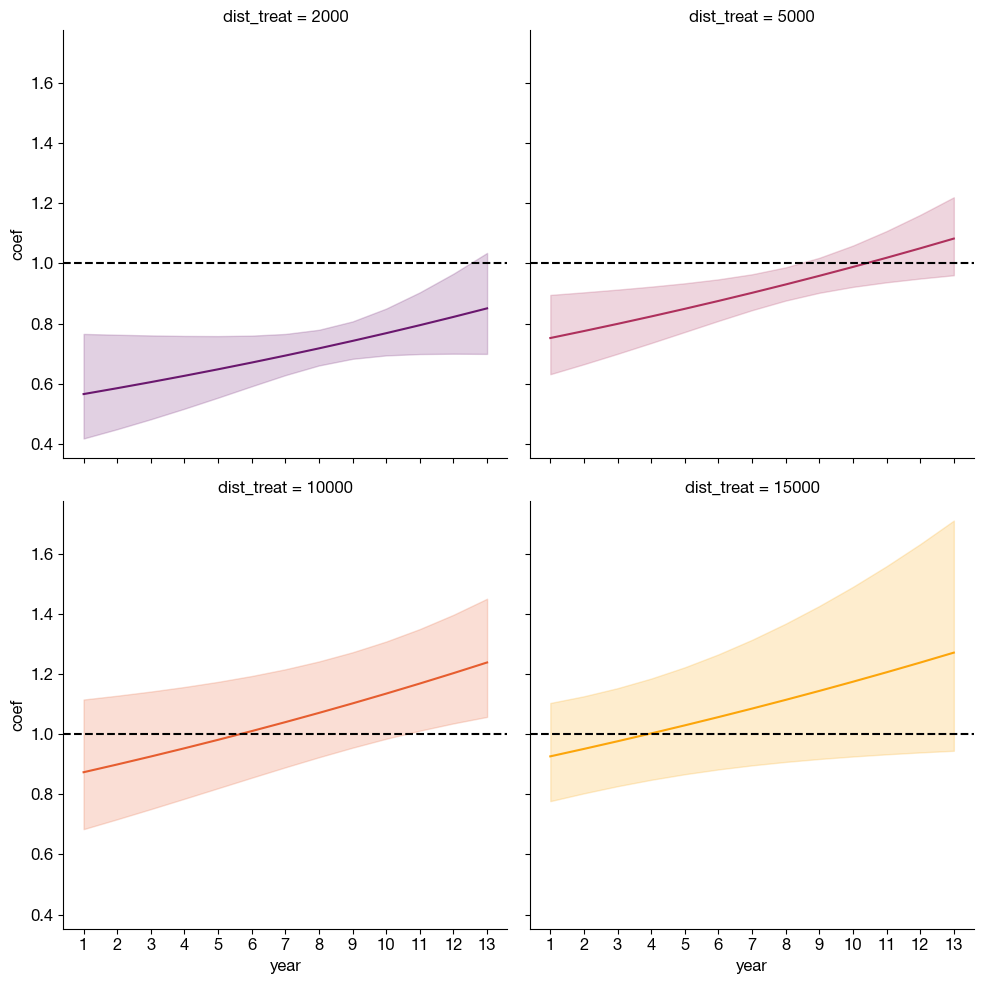

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))

# Create a color dictionary
color_dict = {
    dist_treat: color
    for dist_treat, color in zip(unique_dist_treats, green_colors)
}

# Create the relplot
g = sns.relplot(
    data=final_df[final_df.control_group == "All wildfires"],
    x="year",
    y="coef",
    col="dist_treat",
    hue="dist_treat",
    kind="line",
    legend=False,
    palette=color_dict,
    height=5,
    col_wrap=2,
    aspect=1,
    facet_kws={"sharey": True, "sharex": True},
)

# Add fill_between and other elements to each facet
for ax, (dist_treat, data) in zip(g.axes.flat, g.data.groupby(["dist_treat"])):
    data = data.sort_values("year")
    color = color_dict[dist_treat[0]]

    ax.fill_between(
        data["year"], data["low_ci"], data["high_ci"], alpha=0.2, color=color
    )
    ax.axhline(1, color="black", linestyle="--")

    ax.set_xticks(range(1, 14))
    ax.set_xticklabels(range(1, 14))

# Save plot as PDF
plt.savefig("../figs/main_plot_spills.pdf", dpi=300, transparent=True)

## Supplementary Figure 7: Complete spillover effects 

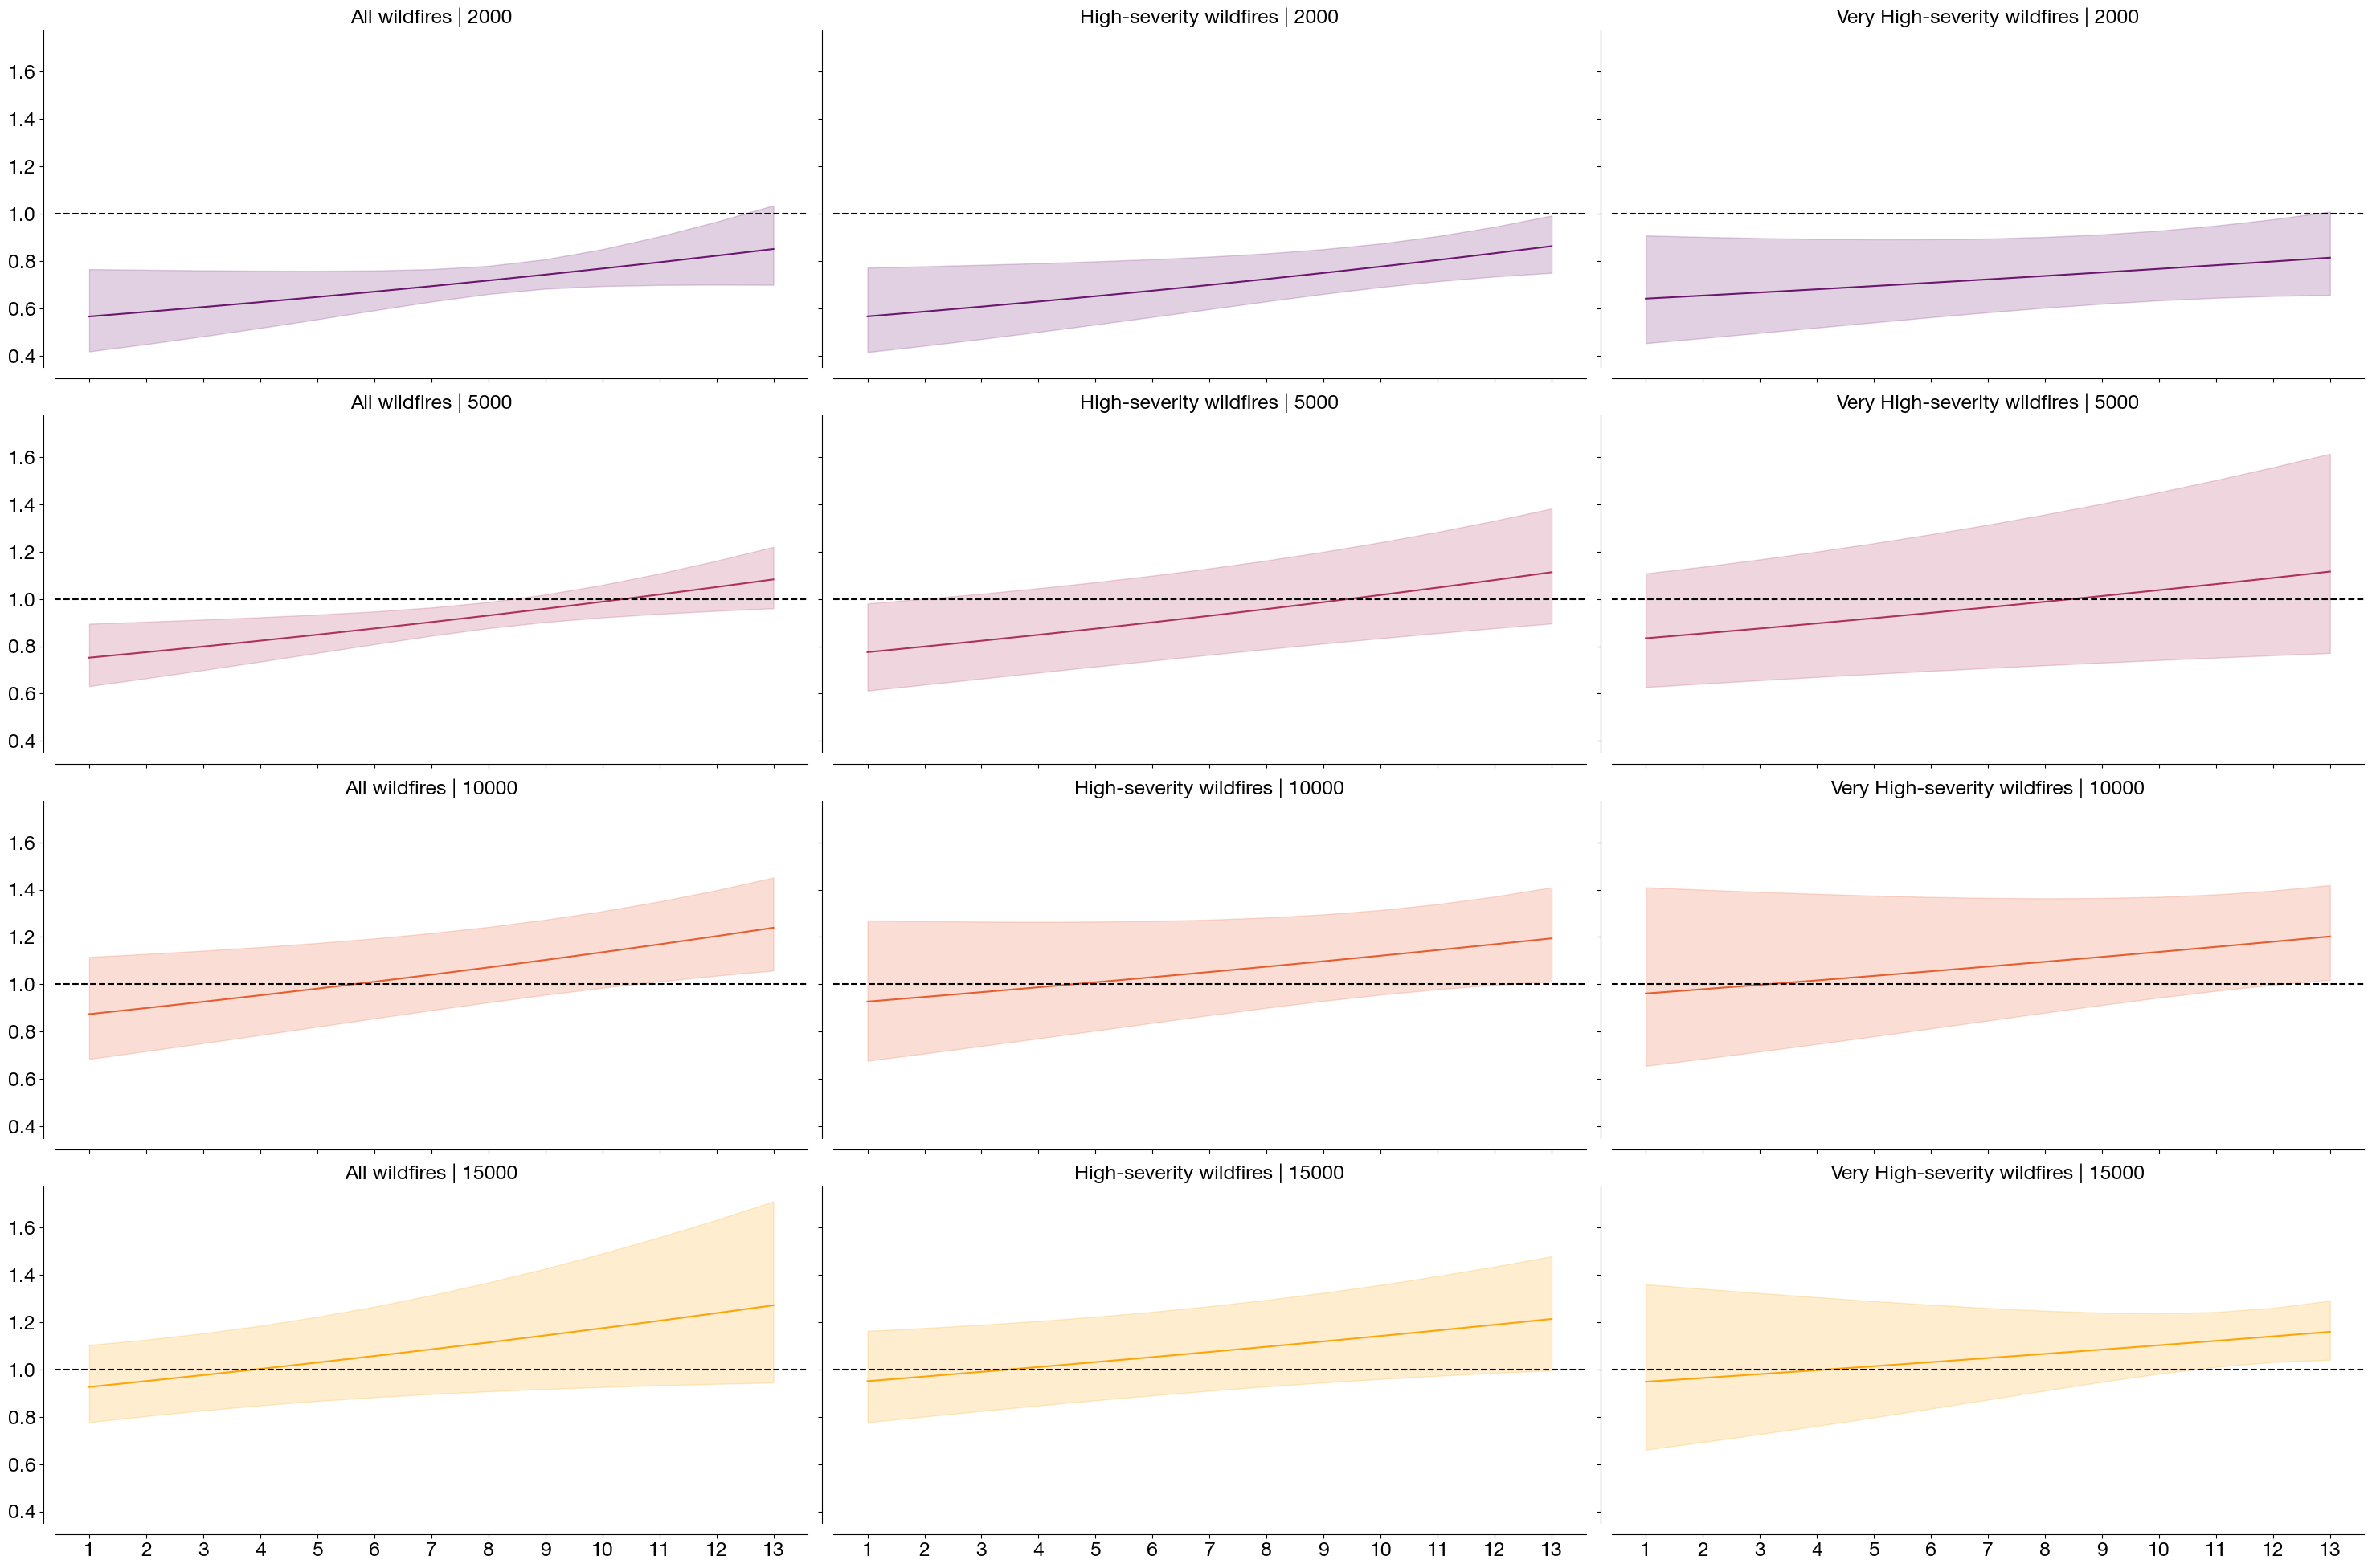

In [10]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 18

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))

# Create a color dictionary
color_dict = {
    dist_treat: color
    for dist_treat, color in zip(unique_dist_treats, green_colors)
}

# Create the relplot
g = sns.relplot(
    data=final_df,
    x="year",
    y="coef",
    row="dist_treat",
    col="control_group",
    hue="dist_treat",
    kind="line",
    legend=False,
    palette=color_dict,
    height=5,
    aspect=2,
    facet_kws={"sharey": True, "sharex": True},
).set_titles("{col_name} | {row_name}")

# # Add fill_between and other elements to each facet
for ax, ((dist_treat, control_group), data) in zip(
    g.axes.flat, g.data.groupby(["dist_treat", "control_group"])
):
    data = data.sort_values("year")
    color = color_dict[dist_treat]

    ax.fill_between(
        data["year"], data["low_ci"], data["high_ci"], alpha=0.2, color=color
    )
    ax.axhline(1, color="black", linestyle="--")

    ax.set_xticks(range(1, 14))
    ax.set_xticklabels(range(1, 14))

    template_plots(
        ax,
        ylab="",
        xlab="",
        rotation_x=0,
        axis_text=18,
    )

# Save plot as PDF
plt.savefig("../figs/main_plot_spills_all.pdf", dpi=400, transparent=True)

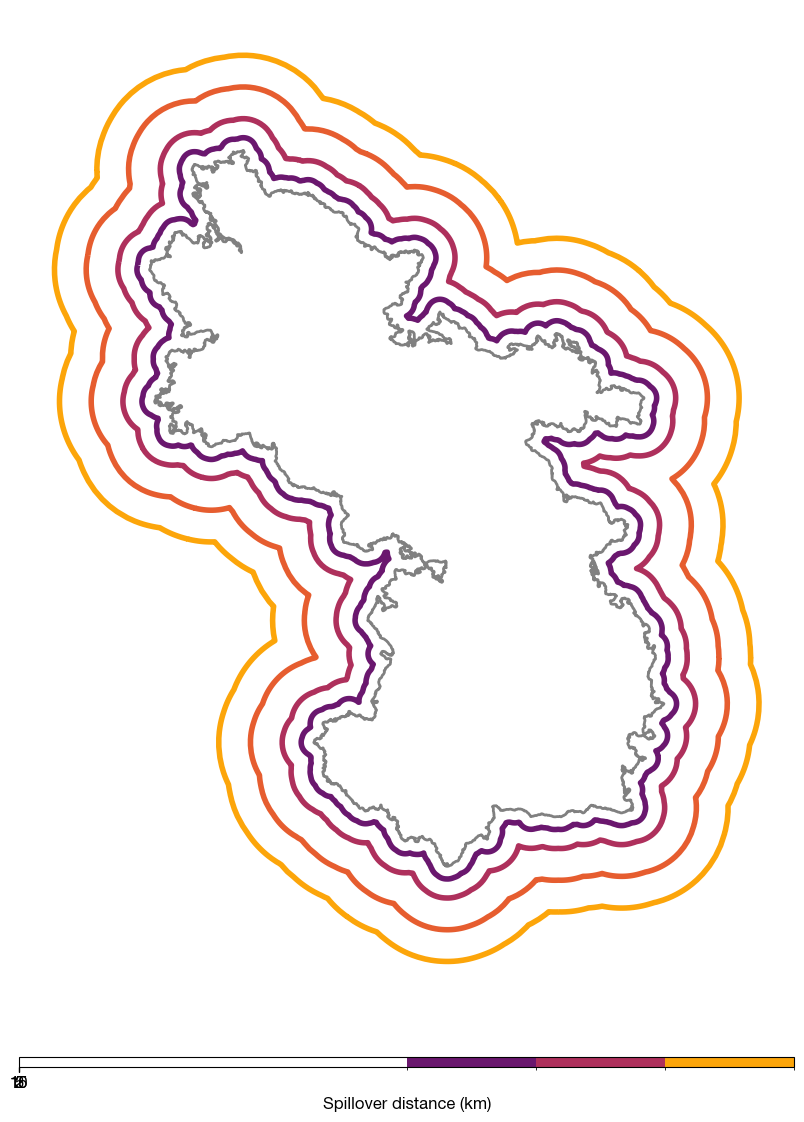

In [11]:
#################### PLOT MAP ####################
event_id = "CA3966012280920200817"

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))


# Plot each distance range with a different color
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(
    ax=ax,
    color="gray",
    linewidth=2,
)

for idx, buf in enumerate(unique_dist_treats):
    # Plot the fire perimeter w/ buffer
    geom = mtbs_ca[mtbs_ca.Event_ID == event_id].geometry.buffer(buf)
    geom.boundary.plot(
        ax=ax,
        color=green_colors[idx],
        linewidth=4,
    )

# Create a color axis (cax) below the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.5)

# Create a ListedColormap and BoundaryNorm
cmap = ListedColormap(green_colors)
norm = BoundaryNorm(unique_dist_treats + [unique_dist_treats[-1] + 1], cmap.N)

# Add a colorbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation="horizontal"
)
cb.set_label("Spillover distance (km)")
cb.set_ticks(unique_dist_treats)
cb.set_ticklabels([f"{int(dist/1000)}" for dist in unique_dist_treats])

# Format the plot
template_plots(ax, no_axis=True, ylab="", xlab="", label_pos=(-0.1, 1.24))


# Save plot as PDF
plt.savefig("../figs/spillover_map.pdf", dpi=300, transparent=True)